In [10]:
import pandas as pd
from pandas.api.types import is_string_dtype

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SequentialFeatureSelector

from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

import time

from sklearn.model_selection import RandomizedSearchCV

import joblib

# 1. Data preparation

In [84]:
train_data_path = "data/train.csv"
full_train_set = pd.read_csv(train_data_path)

In [85]:
full_train_set.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


It seems like column 'unnamed 0' and 'id' duplicates indexes, so I decide to delete these columns.

In [86]:
full_train_set['Unnamed: 0'].unique()

array([     0,      1,      2, ..., 103901, 103902, 103903])

In [87]:
full_train_set.sort_values('id')

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
90131,90131,1,Male,disloyal Customer,48,Business travel,Business,821,3,3,...,5,3,2,5,4,5,5,2,5.0,neutral or dissatisfied
47865,47865,2,Female,Loyal Customer,35,Business travel,Business,821,2,2,...,5,5,5,5,3,5,5,26,39.0,satisfied
44425,44425,3,Male,Loyal Customer,41,Business travel,Business,853,4,4,...,3,3,3,3,4,3,5,0,0.0,satisfied
96450,96450,4,Male,Loyal Customer,50,Business travel,Business,1905,2,2,...,5,5,5,5,3,5,4,0,0.0,satisfied
72524,72524,5,Female,Loyal Customer,49,Business travel,Business,3470,3,3,...,3,3,4,3,3,3,5,0,1.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97767,97767,129874,Female,Loyal Customer,28,Personal Travel,Eco Plus,337,4,2,...,3,1,5,3,4,4,3,0,0.0,neutral or dissatisfied
53459,53459,129875,Female,Loyal Customer,55,Personal Travel,Eco Plus,308,3,4,...,4,4,3,4,4,4,4,0,0.0,neutral or dissatisfied
32973,32973,129878,Male,Loyal Customer,42,Personal Travel,Eco Plus,337,2,5,...,3,3,4,5,4,4,3,6,14.0,neutral or dissatisfied
82052,82052,129879,Male,Loyal Customer,50,Personal Travel,Eco Plus,337,5,4,...,3,4,5,5,3,4,3,31,22.0,satisfied


In [88]:
full_train_set.drop(labels = ['Unnamed: 0', 'id'], axis = 1, inplace = True)
full_train_set.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


Formatting column names and string values in one style.

In [89]:
def format_column_names_and_values(df):
    for column in df.columns:
        new_column_name = column.capitalize()
        df.rename(columns={column: new_column_name}, inplace = True)
        if is_string_dtype(df[new_column_name]):
            df[new_column_name] = df[new_column_name].str.capitalize()
    return df

In [90]:
full_train_set = format_column_names_and_values(full_train_set)
full_train_set.head()

,Gender,Customer type,Age,Type of travel,Class,Flight distance,Inflight wifi service,Departure/arrival time convenient,Ease of online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure delay in minutes,Arrival delay in minutes,Satisfaction
0,Male,Loyal customer,13,Personal travel,Eco plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,Neutral or dissatisfied
1,Male,Disloyal customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,Neutral or dissatisfied
2,Female,Loyal customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,Satisfied
3,Female,Loyal customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,Neutral or dissatisfied
4,Male,Loyal customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,Satisfied


In [91]:
full_train_set = full_train_set.rename(columns = {'On-board service': 'Onboard service'})
full_train_set.head()

,Gender,Customer type,Age,Type of travel,Class,Flight distance,Inflight wifi service,Departure/arrival time convenient,Ease of online booking,Gate location,...,Inflight entertainment,Onboard service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure delay in minutes,Arrival delay in minutes,Satisfaction
0,Male,Loyal customer,13,Personal travel,Eco plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,Neutral or dissatisfied
1,Male,Disloyal customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,Neutral or dissatisfied
2,Female,Loyal customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,Satisfied
3,Female,Loyal customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,Neutral or dissatisfied
4,Male,Loyal customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,Satisfied


Get some information about type of features and missing values.

In [92]:
full_train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103904 non-null  object 
 1   Customer type                      103904 non-null  object 
 2   Age                                103904 non-null  int64  
 3   Type of travel                     103904 non-null  object 
 4   Class                              103904 non-null  object 
 5   Flight distance                    103904 non-null  int64  
 6   Inflight wifi service              103904 non-null  int64  
 7   Departure/arrival time convenient  103904 non-null  int64  
 8   Ease of online booking             103904 non-null  int64  
 9   Gate location                      103904 non-null  int64  
 10  Food and drink                     103904 non-null  int64  
 11  Online boarding                    1039

In [93]:
full_train_set.isnull().sum()

Gender                                 0
Customer type                          0
Age                                    0
Type of travel                         0
Class                                  0
Flight distance                        0
Inflight wifi service                  0
Departure/arrival time convenient      0
Ease of online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
Onboard service                        0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure delay in minutes             0
Arrival delay in minutes             310
Satisfaction                           0
dtype: int64

In [94]:
full_train_set.describe()

,Age,Flight distance,Inflight wifi service,Departure/arrival time convenient,Ease of online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,Onboard service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure delay in minutes,Arrival delay in minutes
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103594.000000
mean,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.178678
std,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.698682
min,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


## 1.2. Checking the default model 
Firstly, I am interested in how well the default model works without additional steps in feature encoding or tuning model hyperparameters.
I use LGBMclassifier for this because it is fast, can use categorical features without encoding, easy can handle NaNs, and gives good results with the last ones.

In [95]:
train_set, test_df = train_test_split(full_train_set, test_size=0.2)

In [96]:
train_set = train_set.reset_index(drop=True)
test_df = test_df.reset_index(drop = True)

In [97]:
LGBM_default = LGBMClassifier(random_state = 42)

In [98]:
for c in train_set.columns:
    col_type = train_set[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        train_set[c] = train_set[c].astype('category')
        test_df[c] = test_df[c].astype('category')

In [99]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83123 entries, 0 to 83122
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   Gender                             83123 non-null  category
 1   Customer type                      83123 non-null  category
 2   Age                                83123 non-null  int64   
 3   Type of travel                     83123 non-null  category
 4   Class                              83123 non-null  category
 5   Flight distance                    83123 non-null  int64   
 6   Inflight wifi service              83123 non-null  int64   
 7   Departure/arrival time convenient  83123 non-null  int64   
 8   Ease of online booking             83123 non-null  int64   
 9   Gate location                      83123 non-null  int64   
 10  Food and drink                     83123 non-null  int64   
 11  Online boarding                    83123 

In [100]:
y_train = train_set.Satisfaction.values
del train_set['Satisfaction']

In [101]:
y_test = test_df.Satisfaction
del test_df['Satisfaction']

In [102]:
LGBM_default.fit(train_set, y_train)
y_pred_default = LGBM_default.predict(test_df)

auc = accuracy_score(y_test, y_pred_default)
f1 = f1_score(y_test, y_pred_default, pos_label='Satisfied')
auc, f1

(0.9645830325778355, 0.9582671807666138)

It looks like the data is so good that the default model shows nice results without any hyperparameter tuning.
Also, I think most models will give pretty good results with this data.
So, firstly I want to check if any model is faster and as good as LGBMClassifier.
Secondly, I want to find out if I can use fewer features for the model and get the same result. For this, I want to use the SequentialFeatureSelector function.
But before doing all of this, I want to encode categorical features into numeric ones, as most models and the SequentialFeatureSelector function don't support categorical features.

## 1.3. Feature encoding

### 1.3.1.Encoding categorical features that have two unique values into 0 and 1

In [103]:
def binary_replacement(column_to_code, unique_value_1, unique_value_2):
    column_to_code = column_to_code.replace(to_replace=[unique_value_1, unique_value_2], value=[0, 1])
    return column_to_code

In [104]:
categorical_features = full_train_set.select_dtypes(include = 'object').columns
categorical_features

Index(['Gender', 'Customer type', 'Type of travel', 'Class', 'Satisfaction'], dtype='object')

In [105]:
for feature in categorical_features:
    print(feature, full_train_set[feature].unique())

Gender ['Male' 'Female']
Customer type ['Loyal customer' 'Disloyal customer']
Type of travel ['Personal travel' 'Business travel']
Class ['Eco plus' 'Business' 'Eco']
Satisfaction ['Neutral or dissatisfied' 'Satisfied']


In [106]:
for name in [('Gender', 'Male', 'Female'),
             ('Customer type', 'Loyal customer', 'Disloyal customer'),
             ('Type of travel', 'Personal travel', 'Business travel')]:
    column_name = name[0]
    unique_val_1 = name[1]
    unique_val_2 = name[2]
    
    full_train_set[column_name] = binary_replacement(full_train_set[column_name], unique_val_1, unique_val_2)

full_train_set.head()

,Gender,Customer type,Age,Type of travel,Class,Flight distance,Inflight wifi service,Departure/arrival time convenient,Ease of online booking,Gate location,...,Inflight entertainment,Onboard service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure delay in minutes,Arrival delay in minutes,Satisfaction
0,0,0,13,0,Eco plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,Neutral or dissatisfied
1,0,1,25,1,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,Neutral or dissatisfied
2,1,0,26,1,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,Satisfied
3,1,0,25,1,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,Neutral or dissatisfied
4,0,0,61,1,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,Satisfied


### 1.3.2. Label Encoding of target values
As recommended by the documentation, I use LabelEncoder to encode only the target labels.

In [107]:
label_encoder = LabelEncoder()
full_train_set['Satisfaction'] = label_encoder.fit_transform(full_train_set['Satisfaction'])
full_train_set.head()

,Gender,Customer type,Age,Type of travel,Class,Flight distance,Inflight wifi service,Departure/arrival time convenient,Ease of online booking,Gate location,...,Inflight entertainment,Onboard service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure delay in minutes,Arrival delay in minutes,Satisfaction
0,0,0,13,0,Eco plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,0
1,0,1,25,1,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,0
2,1,0,26,1,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,1
3,1,0,25,1,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,0
4,0,0,61,1,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,1


The 'Class' feature is nominal, so I will use frequency encoding to turn this one into a numeric one.
As frequency encoding uses the length of the dataset, I want to split full_train_set into the train and validation datasets before using frequency encoding to avoid data leakage.

## 1.4. Dataset split

In [108]:
train_df, val_df = train_test_split(full_train_set, test_size=0.2)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop = True)

y_train = train_df.Satisfaction.values
y_val = val_df.Satisfaction.values

del train_df['Satisfaction']
del val_df['Satisfaction']

## 1.5. Class feature frequency encoding 

In [109]:
def frequency_encoding(data_set, columns_list):
    for column in columns_list:
        frequency_group = data_set.groupby(column).size()/len(data_set)
        name = column + '_fr'
        data_set[name] = 0
        data_set[name] = data_set[column].apply(lambda x : frequency_group[x])
    return data_set

In [110]:
train_df = np.around(frequency_encoding(train_df, ['Class']),2)
val_df = np.around(frequency_encoding(val_df, ['Class']), 2)
train_df.head()

,Gender,Customer type,Age,Type of travel,Class,Flight distance,Inflight wifi service,Departure/arrival time convenient,Ease of online booking,Gate location,...,Inflight entertainment,Onboard service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure delay in minutes,Arrival delay in minutes,Class_fr
0,1,0,42,0,Eco,280,2,5,2,2,...,3,3,2,1,2,3,2,0,0.0,0.45
1,1,0,45,1,Business,349,3,3,3,3,...,4,4,4,4,1,4,1,0,0.0,0.48
2,0,0,44,1,Business,787,1,1,1,1,...,4,4,4,4,4,4,4,20,6.0,0.48
3,1,0,27,0,Eco,909,3,1,3,3,...,2,4,2,3,1,3,2,0,0.0,0.45
4,0,0,56,0,Eco,1744,4,4,4,4,...,1,3,2,3,3,5,1,0,0.0,0.45


In [111]:
train_df.Class_fr.unique()

array([0.45, 0.48, 0.07])

In [112]:
val_df.Class_fr.unique()

array([0.48, 0.45, 0.07])

In [113]:
val_df.head()

,Gender,Customer type,Age,Type of travel,Class,Flight distance,Inflight wifi service,Departure/arrival time convenient,Ease of online booking,Gate location,...,Inflight entertainment,Onboard service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure delay in minutes,Arrival delay in minutes,Class_fr
0,0,0,50,1,Business,1390,5,5,5,5,...,4,4,4,4,4,4,3,0,10.0,0.48
1,0,0,53,1,Business,1620,2,2,4,2,...,4,4,4,4,5,4,3,0,0.0,0.48
2,0,1,46,1,Business,2125,4,4,4,5,...,5,4,5,4,3,4,5,0,0.0,0.48
3,0,0,36,0,Eco,1020,1,5,1,3,...,4,5,3,5,5,3,4,11,2.0,0.45
4,0,1,25,1,Business,602,1,0,1,4,...,5,3,5,5,3,4,5,0,0.0,0.48


In [114]:
del train_df['Class']
del val_df['Class']

# 2.Checking different models

Among all chosen models, only HistGradientBoostingClassifier has native support for missing values, so for this classifier, I use the train and validation datasets without any changes, and for others - a copy of these datasets, as I need to fill in missing values in the 'Arrival delay in minutes' column.

In [33]:
train_df_copy = train_df.copy()
val_df_copy = val_df.copy()

Data from the 'Arrival delay in minutes' column looks skewed, so I use the median for filling in the missing values in this column.

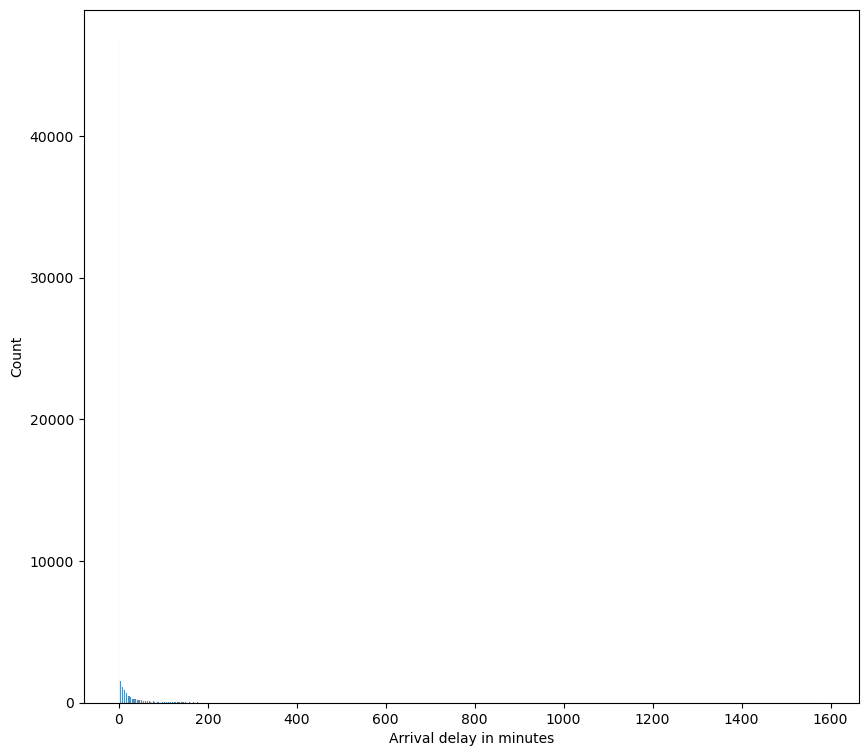

In [34]:
plt.figure(figsize = (10, 9))
res = sns.histplot(train_df['Arrival delay in minutes'])
plt.show()

In [35]:
train_df_copy['Arrival delay in minutes'].median()

0.0

In [36]:
val_df_copy['Arrival delay in minutes'].median()

0.0

As the median for train_df and val_df equals 0.0, I use one variable for both datasets.

In [37]:
arrival_delay_median = train_df_copy['Arrival delay in minutes'].median()
train_df_copy['Arrival delay in minutes'] = train_df_copy['Arrival delay in minutes'].fillna(arrival_delay_median)
val_df_copy['Arrival delay in minutes'] = val_df_copy['Arrival delay in minutes'].fillna(arrival_delay_median)

In [38]:
train_df_copy.isnull().sum()

Gender                               0
Customer type                        0
Age                                  0
Type of travel                       0
Flight distance                      0
Inflight wifi service                0
Departure/arrival time convenient    0
Ease of online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
Onboard service                      0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure delay in minutes           0
Arrival delay in minutes             0
Class_fr                             0
dtype: int64

In [39]:
def model_comparison(model, train, y_train, val, y_val):
    start = time.time()
    model.fit(train, y_train)
    stop = time.time()
    y_pred = model.predict(val)
    
    auc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    training_time = stop-start
    return auc, f1, training_time

In [40]:
sgd = SGDClassifier()
decision_tree = DecisionTreeClassifier()
gradient_boost = GradientBoostingClassifier()
random_forest = RandomForestClassifier()
hist_gradient_boost = HistGradientBoostingClassifier()

In [41]:
model_comparison_no_nones = []
for model in [sgd, decision_tree, gradient_boost, random_forest, hist_gradient_boost, LGBM_default]:
    name = str(model)
    auc, f1, tr_time = model_comparison(model, train_df_copy, y_train, val_df_copy, y_val)
    model_comparison_no_nones.append((name,auc, f1, tr_time))

In [42]:
df_scores = pd.DataFrame(model_comparison_no_nones, columns = ['model_name','auc', 'f1', 'time'])
df_scores.sort_values(by='time', ascending = False)

,model_name,auc,f1,time
2,GradientBoostingClassifier(),0.942496,0.932535,11.924550
3,RandomForestClassifier(),0.962803,0.956281,8.032415
0,SGDClassifier(),0.817478,0.749720,3.595308
4,HistGradientBoostingClassifier(),0.965064,0.958909,2.363922
5,LGBMClassifier(random_state=42),0.965401,0.959257,1.339908
1,DecisionTreeClassifier(),0.945383,0.936857,0.472238


In [43]:
df_scores.sort_values(by='auc', ascending = False)

,model_name,auc,f1,time
5,LGBMClassifier(random_state=42),0.965401,0.959257,1.339908
4,HistGradientBoostingClassifier(),0.965064,0.958909,2.363922
3,RandomForestClassifier(),0.962803,0.956281,8.032415
1,DecisionTreeClassifier(),0.945383,0.936857,0.472238
2,GradientBoostingClassifier(),0.942496,0.932535,11.924550
0,SGDClassifier(),0.817478,0.749720,3.595308


So the best two models are HistGradientBoostingClassifier and LGBMClassifier. The last one is much faster, and the AUC score of the first one is ~0.0002 better.
But before choosing the model, I also want to compare how both models deal with datasets with NaNs.

In [44]:
model_comparison_nan = []
for model in [hist_gradient_boost, LGBM_default]:
    name = str(model)
    auc, f1, tr_time = model_comparison(model, train_df, y_train, val_df, y_val)
    model_comparison_nan.append((name,auc, f1, tr_time))

In [45]:
df_scores_nan = pd.DataFrame(model_comparison_nan, columns = ['model_name','auc', 'f1', 'time'])
df_scores_nan.sort_values(by='time', ascending = False)

,model_name,auc,f1,time
0,HistGradientBoostingClassifier(),0.965112,0.958940,2.979404
1,LGBMClassifier(random_state=42),0.965449,0.959325,1.223664


I choose LGBMClassifier, as it is much faster, and the difference in AUC and f1 scores is insignificant.

# 3. Feature Selection

As I have mentioned before, I use SequentialFeatureSelector to find the minimum number of features that will give almost the same performance as if I had used all of them.
As the maximum number of features to select by SequentialFeatureSelector - I choose to use 70% of the feature number. 

In [ ]:
def feature_selection(max_feature_num, model, train, y_train, val, y_val):
    score_dict = {}
    max_feature_num = max_feature_num+1
    
    for num in range(1, max_feature_num, 1):
    
        sfs = SequentialFeatureSelector(model,
                                        n_features_to_select = num,
                                        scoring='accuracy',
                                        n_jobs = -1)

        sfs.fit(train, y_train)
        features = sfs.get_feature_names_out(train.columns)

        model.fit(train[features], y_train)
        y_pred = model.predict(val[features])

        auc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)

        print(num, features, auc, f1)
        score_dict[num] = (features, auc, f1)

    return score_dict

In [ ]:
LGBM = LGBMClassifier(random_state = 42)

In [ ]:
%%time


max_feature_num = round(train_df.shape[1]*0.7)
print('Number of all features - {} \n70% of feature number {}'.format(train_df.shape[1], max_feature_num))

default_features_score = feature_selection(max_feature_num, LGBM, train_df, y_train, val_df, y_val)

In [ ]:
df_scores = pd.DataFrame(default_features_score.values(), columns = ['features', 'auc', 'f1'], 
                         index=np.arange(1, max_feature_num+1))
df_scores.sort_values(by='auc', ascending = False)

In [ ]:
df_scores.sort_values(by='f1', ascending = False)

So using only these 12 features for the training of the model - 'Customer Type' 'Age', 'Type o Travel', 'Inflight wifi service', 'Gate location', 'Online boarding', 'Seat comfort',   'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Class_fr' - gives almost the same accuracy and f1-score as using all default features for training.
Before hyperparameter tuning, I want to create new features and check if it is possible with new ones to use fewer than 12 features for training and get the same result. 

# 3. New features

So I want to combine some correlated and uncorrelated features based on the correlation matrix.

In [ ]:
corr_matrix_big = full_train_set.corr()

In [ ]:
mask = np.zeros_like(corr_matrix_big)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (130, 100))
res = sns.heatmap(corr_matrix_big,
                  fmt='.3f',
                  linewidths=0.1,
                  annot_kws={"size": 60}, cmap="YlGnBu", annot = True, mask = mask)
res.set_xticklabels(res.get_xmajorticklabels(), rotation = 90, fontsize = 60)
res.set_yticklabels(res.get_ymajorticklabels(), rotation = 0, fontsize = 60)
plt.show()


## 3.1. Combining the most correlated features
It follows from the above correlation matrix that the most correlated features with one another are 'Departure delay in minutes' and 'Arrival delay in minutes'.
So I add them and create a new feature - 'Total Delay Time'.

In [ ]:
train_df.columns

In [ ]:
train_df['Total delay time'] = train_df['Departure delay in minutes'] + train_df['Arrival delay in minutes']
val_df['Total delay time'] = val_df['Departure delay in minutes'] + val_df['Arrival delay in minutes']

train_df

## 3.2. Mean and the sum of rating features
I also want to check if the sum of all rating features can imply model training more significantly than every rating separately.

In [ ]:
Rating_scales_columns = [
'Inflight wifi service',  
'Departure/arrival time convenient', 
'Ease of online booking', 
'Gate location', 
'Food and drink',
'Online boarding', 
'Seat comfort',
'Inflight entertainment', 
'Onboard service', 
'Leg room service', 
'Baggage handling',
'Checkin service',
'Inflight service', 
'Cleanliness'] 

In [ ]:
train_df['Sum_rating_scales'] = 0
train_df['Mean_rating_scales'] = 0

val_df['Sum_rating_scales'] = 0
val_df['Mean_rating_scales'] = 0

In [ ]:
train_df[Rating_scales_columns].describe()

In [ ]:
train_df['Sum_rating_scales'] = train_df[Rating_scales_columns].sum(axis = 1)
train_df['Mean_rating_scales'] = train_df[Rating_scales_columns].mean(axis = 1)

train_df

In [ ]:
val_df['Sum_rating_scales'] = val_df[Rating_scales_columns].sum(axis = 1)
val_df['Mean_rating_scales'] = val_df[Rating_scales_columns].mean(axis = 1)

val_df

## 3.3. Frequency encoding and new feature combinations

I used to combine several frequency-encoded uncorrelated features in new ones with other datasets, and this improved model accuracy well. So I want to check this method with this dataset and, based on a correlation matrix, choose several pairs of correlated and uncorrelated features, encode them with frequency encoding, and sum the result of encoding in new features.

### 3.3.1. Combination of correlated features in train_df and val_df
#### 3.3.1.1. train_df

In [ ]:
frequency_encoding(train_df, ['Food and drink'])
frequency_encoding(train_df, ['Cleanliness'])
frequency_encoding(train_df, ['Inflight service'])
frequency_encoding(train_df, ['Baggage handling'])
frequency_encoding(train_df, ['Departure delay in minutes'])
frequency_encoding(train_df, ['Ease of online booking'])
frequency_encoding(train_df, ['Inflight wifi service'])
frequency_encoding(train_df, ['Seat comfort'])

In [ ]:
train_df['Food_cleanliness'] = train_df['Food and drink_fr']+train_df['Cleanliness_fr']
train_df['Inflight_service_baggage']=train_df['Inflight service_fr']+train_df['Baggage handling_fr']
train_df['Ease_booking_wifi']=train_df['Ease of online booking_fr']+train_df['Inflight wifi service_fr']
train_df['Cleanliness_seat']=train_df['Cleanliness_fr']+train_df['Seat comfort_fr']

In [ ]:
train_df_copy = train_df.copy()
train_df_copy['Arrival delay in minutes'] = train_df_copy['Arrival delay in minutes'].fillna('None')
frequency_encoding(train_df_copy, ['Arrival delay in minutes'])

train_df['Freq_delay'] =train_df['Departure delay in minutes_fr']+train_df_copy['Arrival delay in minutes_fr']
train_df

#### 3.3.1.2. val_df

In [ ]:
frequency_encoding(val_df, ['Food and drink'])
frequency_encoding(val_df, ['Cleanliness'])
frequency_encoding(val_df, ['Inflight service'])
frequency_encoding(val_df, ['Baggage handling'])
frequency_encoding(val_df, ['Departure delay in minutes'])
frequency_encoding(val_df, ['Ease of online booking'])
frequency_encoding(val_df, ['Inflight wifi service'])
frequency_encoding(val_df, ['Seat comfort'])

In [ ]:
val_df['Food_cleanliness'] = val_df['Food and drink_fr']+val_df['Cleanliness_fr']
val_df['Inflight_service_baggage']=val_df['Inflight service_fr']+val_df['Baggage handling_fr']
val_df['Ease_booking_wifi']=val_df['Ease of online booking_fr']+val_df['Inflight wifi service_fr']
val_df['Cleanliness_seat']=val_df['Cleanliness_fr']+val_df['Seat comfort_fr']

In [ ]:
val_df_copy = val_df.copy()
val_df_copy['Arrival delay in minutes'] = val_df_copy['Arrival delay in minutes'].fillna('None')
frequency_encoding(val_df_copy, ['Arrival delay in minutes'])

val_df['Freq_delay'] =val_df['Departure delay in minutes_fr']+val_df_copy['Arrival delay in minutes_fr']
val_df

### 3.3.2. Combination of uncorrelated features in train_df and val_df
#### 3.3.2.1. train_df

In [ ]:
frequency_encoding(train_df, ['Gender'])
frequency_encoding(train_df, ['Type of travel'])
frequency_encoding(train_df, ['Onboard service'])
frequency_encoding(train_df, ['Age'])
frequency_encoding(train_df, ['Flight distance'])
frequency_encoding(train_df, ['Checkin service'])

In [ ]:
train_df['Gender_inflight_service'] = train_df['Gender_fr']+train_df['Inflight service_fr']
train_df['Type_travel_onboard_serv']=train_df['Type of travel_fr']+train_df['Onboard service_fr']
train_df['Age_baggage']=train_df['Age_fr']+train_df['Baggage handling_fr']
train_df['Distance_food']=train_df['Flight distance_fr']+train_df['Food and drink_fr']
train_df['Checkin_inflight_wifi']=train_df['Checkin service_fr']+train_df['Inflight wifi service_fr']

#### 3.3.2.2. val_df

In [ ]:
frequency_encoding(val_df, ['Gender'])
frequency_encoding(val_df, ['Type of travel'])
frequency_encoding(val_df, ['Onboard service'])
frequency_encoding(val_df, ['Age'])
frequency_encoding(val_df, ['Flight distance'])
frequency_encoding(val_df, ['Checkin service'])

In [ ]:
val_df['Gender_inflight_service'] = val_df['Gender_fr']+val_df['Inflight service_fr']
val_df['Type_travel_onboard_serv']=val_df['Type of travel_fr']+val_df['Onboard service_fr']
val_df['Age_baggage']=val_df['Age_fr']+val_df['Baggage handling_fr']
val_df['Distance_food']=val_df['Flight distance_fr']+val_df['Food and drink_fr']
val_df['Checkin_inflight_wifi']=val_df['Checkin service_fr']+val_df['Inflight wifi service_fr']

In [ ]:
train_df.head()

In [ ]:
val_df.head()

In [ ]:
train_df.isnull().sum()

In [ ]:
train_df.drop(labels = ['Food and drink_fr',
                        'Cleanliness_fr',
                        'Inflight service_fr',
                        'Baggage handling_fr',
                        'Departure delay in minutes_fr',
                        'Ease of online booking_fr',
                        'Inflight wifi service_fr',
                        'Seat comfort_fr',
                        'Gender_fr',
                        'Type of travel_fr',
                        'Onboard service_fr',
                        'Age_fr',
                        'Flight distance_fr',
                        'Checkin service_fr'], axis = 1, inplace = True)

In [ ]:
val_df.drop(labels = ['Food and drink_fr',
                        'Cleanliness_fr',
                        'Inflight service_fr',
                        'Baggage handling_fr',
                        'Departure delay in minutes_fr',
                        'Ease of online booking_fr',
                        'Inflight wifi service_fr',
                        'Seat comfort_fr',
                        'Gender_fr',
                        'Type of travel_fr',
                        'Onboard service_fr',
                        'Age_fr',
                        'Flight distance_fr',
                        'Checkin service_fr'], axis = 1, inplace = True)

## 3.4. Feature selection with new features
Again I will use SequentialFeatureSelector to find the minimum number of features that will give almost the same performance as if I had used all of them.
This time I choose to use half of all features number as the maximum number of features to select by SequentialFeatureSelector.

In [ ]:
%%time


max_feature_num = round(train_df.shape[1]/2)
print('Number of all features - {} \nhalf of feature number {}'.format(train_df.shape[1], max_feature_num))

new_features_score = feature_selection(max_feature_num, LGBM, train_df, y_train, val_df, y_val)

In [ ]:
df_new_features_score = pd.DataFrame(new_features_score.values(), columns = ['features', 'auc', 'f1'],
                                      index=np.arange(1, max_feature_num+1))
df_new_features_score.sort_values(by='auc', ascending = False)

In [ ]:
df_new_features_score.sort_values(by='f1', ascending = False)

The new features didn't improve model accuracy hence, I won't use them for training.

# 4. Training model
## 4.1. Hyperparameter tuning

I want to use RandomizedSearchCV for hyperparameter tuning. Also, I suppose that hyperparameter tuning won't change accuracy and f1-score for the model trained on the training set with 14 features, however, it probably can improve the performance of the model trained on the training set with 10 features. I want to check this.

In [ ]:
default_features_score[14]

In [ ]:
default_features_score[10]

In [115]:
columns_10 = ['Customer type', 'Age', 'Type of travel', 'Inflight wifi service',
        'Gate location', 'Online boarding', 'Baggage handling',
        'Checkin service', 'Inflight service', 'Class_fr']

columns_14 = ['Customer type', 'Age', 'Type of travel', 'Inflight wifi service',
        'Gate location', 'Online boarding', 'Seat comfort',
        'Inflight entertainment', 'Onboard service', 'Baggage handling',
        'Checkin service', 'Inflight service', 'Cleanliness', 'Class_fr']

In [116]:
column_list=[]
column_list.extend([columns_10,columns_14])

In [55]:
# param_grid, num_iter, cv_num, scoring and model - parameters necessary for RandomizedSearchCV()

# param_grid - dictionary with parameters to try
# num_iter - number of parameter settings that are sampled 
# cv_num - determines the cross-validation splitting strategy
# scoring - strategy to evaluate the performance of the cross-validated model
# model - estimator

def hyperparameter_tuning(param_grid, num_iter, cv_num, scoring, train_set, y_train, model):
    random_search = RandomizedSearchCV(model, param_grid, n_iter=num_iter, cv=cv_num, scoring=scoring, n_jobs=-1)
    
    result = random_search.fit(train_set, y_train)
    
    best_score = random_search.best_score_
    best_param = random_search.best_params_
    return best_score, best_param

In [56]:
n_estimators_lgbm = np.arange(0, 600, step=2)
max_depth_lgbm = [1, 2, 3, 4, 5, 6, 10, 15, 20, 25, 30, 35, 50, 70, 60, 80, 90, 100, 200, None]
num_leaves_lgbm = np.arange(2, 200, step=1)


param_grid_lgbm = {
    'n_estimators': n_estimators_lgbm,
    'max_depth': max_depth_lgbm,
    'num_leaves': num_leaves_lgbm,
 }

In [ ]:
%%time


ind = 1
score_table = {}
for column in column_list:
    score, param =hyperparameter_tuning(param_grid_lgbm, 100, 5, 'accuracy', train_df[column], y_train, LGBM)
    print(ind, column)
    print(score, param)
    score_table[ind] = (score, param, column)
    ind+=1

In [ ]:
df_scores_param = pd.DataFrame(score_table.values(), columns = ['score_auc', 'param', 'columns'], index=np.arange(1, 3))
df_scores_param.sort_values(by='score_auc', ascending = False)

In [117]:
L_10 = LGBMClassifier(num_leaves=53, n_estimators=174, max_depth=10, random_state=42)
L_10.fit(train_df[columns_10], y_train)
y_pred_10 = L_10.predict(val_df[columns_10])

auc = accuracy_score(y_val, y_pred_10)
f1 = f1_score(y_val, y_pred_10)
auc, f1

(0.9594822193349695, 0.9526007655933348)

In [118]:
L_14 = LGBMClassifier(num_leaves=76, n_estimators=132, max_depth=None, random_state=42)
L_14.fit(train_df[columns_14], y_train)
y_pred_14 = L_14.predict(val_df[columns_14])

auc = accuracy_score(y_val, y_pred_14)
f1 = f1_score(y_val, y_pred_14)
auc, f1

(0.964967999615033, 0.9589535408209291)

I decide to use 14 features for training the final model. 

## 4.2 Final model

I train the best model on the full training set before testing it.

In [119]:
best_model = LGBMClassifier(num_leaves=76, n_estimators=132, max_depth=None, random_state=42)

In [120]:
full_train_set

,Gender,Customer type,Age,Type of travel,Class,Flight distance,Inflight wifi service,Departure/arrival time convenient,Ease of online booking,Gate location,...,Inflight entertainment,Onboard service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure delay in minutes,Arrival delay in minutes,Satisfaction
0,0,0,13,0,Eco plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,0
1,0,1,25,1,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,0
2,1,0,26,1,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,1
3,1,0,25,1,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,0
4,0,0,61,1,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,1,1,23,1,Eco,192,2,1,2,3,...,2,3,1,4,2,3,2,3,0.0,0
103900,0,0,49,1,Business,2347,4,4,4,4,...,5,5,5,5,5,5,4,0,0.0,1
103901,0,1,30,1,Business,1995,1,1,1,3,...,4,3,2,4,5,5,4,7,14.0,0
103902,1,1,22,1,Eco,1000,1,1,1,5,...,1,4,5,1,5,4,1,0,0.0,0


In [121]:
full_train_set = full_train_set.reset_index(drop=True)
full_train_set['Satisfaction'] = label_encoder.fit_transform(full_train_set['Satisfaction'])
y_full_train_set = full_train_set.Satisfaction
full_train_set.head()

,Gender,Customer type,Age,Type of travel,Class,Flight distance,Inflight wifi service,Departure/arrival time convenient,Ease of online booking,Gate location,...,Inflight entertainment,Onboard service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure delay in minutes,Arrival delay in minutes,Satisfaction
0,0,0,13,0,Eco plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,0
1,0,1,25,1,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,0
2,1,0,26,1,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,1
3,1,0,25,1,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,0
4,0,0,61,1,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,1


In [122]:
full_train_set = np.around(frequency_encoding(full_train_set, ['Class']), 2)
full_train_set.Class_fr.unique()

array([0.07, 0.48, 0.45])

In [123]:
best_model= LGBMClassifier(num_leaves=76, n_estimators=132, max_depth=None, random_state=42)
best_model.fit(full_train_set[columns_14], y_full_train_set)

LGBMClassifier(max_depth=None, n_estimators=132, num_leaves=76, random_state=42)

# 5. Prepare test set

I have a separate test set, and I repeat the same operations with features as I did with ones in the training set:
- delete the 'Unnamed: 0' and 'id' columns
- format column names and string values in one style
- encode 'Gender', 'Customer Type', and 'Type of travel' columns in 0 and 1
- use Label Encoding of target values
- use frequency encoding for the 'Class' column

In [11]:
test_data_path = "data/test.csv"

In [12]:
test_set = pd.read_csv(test_data_path)

In [13]:
test_set.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [16]:
test_set.loc[24]

Unnamed: 0                                                24
id                                                     82602
Gender                                                Female
Customer Type                              disloyal Customer
Age                                                       30
Type of Travel                               Business travel
Class                                                    Eco
Flight Distance                                          528
Inflight wifi service                                      4
Departure/Arrival time convenient                          3
Ease of Online booking                                     5
Gate location                                              3
Food and drink                                             2
Online boarding                                            5
Seat comfort                                               2
Inflight entertainment                                     2
On-board service        

In [128]:
test_set.drop(labels = ['Unnamed: 0', 'id'], axis = 1, inplace = True)
test_set.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [129]:
test_set = format_column_names_and_values(test_set)
test_set.head()

,Gender,Customer type,Age,Type of travel,Class,Flight distance,Inflight wifi service,Departure/arrival time convenient,Ease of online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure delay in minutes,Arrival delay in minutes,Satisfaction
0,Female,Loyal customer,52,Business travel,Eco,160,5,4,3,4,...,5,5,5,5,2,5,5,50,44.0,Satisfied
1,Female,Loyal customer,36,Business travel,Business,2863,1,1,3,1,...,4,4,4,4,3,4,5,0,0.0,Satisfied
2,Male,Disloyal customer,20,Business travel,Eco,192,2,0,2,4,...,2,4,1,3,2,2,2,0,0.0,Neutral or dissatisfied
3,Male,Loyal customer,44,Business travel,Business,3377,0,0,0,2,...,1,1,1,1,3,1,4,0,6.0,Satisfied
4,Female,Loyal customer,49,Business travel,Eco,1182,2,3,4,3,...,2,2,2,2,4,2,4,0,20.0,Satisfied


In [130]:
test_set = test_set.rename(columns = {'On-board service': 'Onboard service'})
test_set.head()

,Gender,Customer type,Age,Type of travel,Class,Flight distance,Inflight wifi service,Departure/arrival time convenient,Ease of online booking,Gate location,...,Inflight entertainment,Onboard service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure delay in minutes,Arrival delay in minutes,Satisfaction
0,Female,Loyal customer,52,Business travel,Eco,160,5,4,3,4,...,5,5,5,5,2,5,5,50,44.0,Satisfied
1,Female,Loyal customer,36,Business travel,Business,2863,1,1,3,1,...,4,4,4,4,3,4,5,0,0.0,Satisfied
2,Male,Disloyal customer,20,Business travel,Eco,192,2,0,2,4,...,2,4,1,3,2,2,2,0,0.0,Neutral or dissatisfied
3,Male,Loyal customer,44,Business travel,Business,3377,0,0,0,2,...,1,1,1,1,3,1,4,0,6.0,Satisfied
4,Female,Loyal customer,49,Business travel,Eco,1182,2,3,4,3,...,2,2,2,2,4,2,4,0,20.0,Satisfied


## 5.1. Feature encoding

### 5.1.1.Encoding categorical features that have two unique values into 0 and 1

In [131]:
for name in [('Gender', 'Male', 'Female'),
             ('Customer type', 'Loyal customer', 'Disloyal customer'),
             ('Type of travel', 'Personal travel', 'Business travel')]:
    column_name = name[0]
    unique_val_1 = name[1]
    unique_val_2 = name[2]
    
    test_set[column_name] = binary_replacement(test_set[column_name], unique_val_1, unique_val_2)

test_set.head()

,Gender,Customer type,Age,Type of travel,Class,Flight distance,Inflight wifi service,Departure/arrival time convenient,Ease of online booking,Gate location,...,Inflight entertainment,Onboard service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure delay in minutes,Arrival delay in minutes,Satisfaction
0,1,0,52,1,Eco,160,5,4,3,4,...,5,5,5,5,2,5,5,50,44.0,Satisfied
1,1,0,36,1,Business,2863,1,1,3,1,...,4,4,4,4,3,4,5,0,0.0,Satisfied
2,0,1,20,1,Eco,192,2,0,2,4,...,2,4,1,3,2,2,2,0,0.0,Neutral or dissatisfied
3,0,0,44,1,Business,3377,0,0,0,2,...,1,1,1,1,3,1,4,0,6.0,Satisfied
4,1,0,49,1,Eco,1182,2,3,4,3,...,2,2,2,2,4,2,4,0,20.0,Satisfied


### 5.1.2. Label Encoding of target values
As recommended by the documentation, I use LabelEncoder to encode only the target labels.

In [132]:
test_set['Satisfaction'] = label_encoder.fit_transform(test_set['Satisfaction'])
test_set.head()

,Gender,Customer type,Age,Type of travel,Class,Flight distance,Inflight wifi service,Departure/arrival time convenient,Ease of online booking,Gate location,...,Inflight entertainment,Onboard service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure delay in minutes,Arrival delay in minutes,Satisfaction
0,1,0,52,1,Eco,160,5,4,3,4,...,5,5,5,5,2,5,5,50,44.0,1
1,1,0,36,1,Business,2863,1,1,3,1,...,4,4,4,4,3,4,5,0,0.0,1
2,0,1,20,1,Eco,192,2,0,2,4,...,2,4,1,3,2,2,2,0,0.0,0
3,0,0,44,1,Business,3377,0,0,0,2,...,1,1,1,1,3,1,4,0,6.0,1
4,1,0,49,1,Eco,1182,2,3,4,3,...,2,2,2,2,4,2,4,0,20.0,1


### 5.1.3. Class feature frequency encoding 

In [133]:
test_set = np.around(frequency_encoding(test_set, ['Class']), 2)

In [134]:
test_set.Class_fr.unique()

array([0.45, 0.48, 0.07])

In [135]:
test_set.head()

,Gender,Customer type,Age,Type of travel,Class,Flight distance,Inflight wifi service,Departure/arrival time convenient,Ease of online booking,Gate location,...,Onboard service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure delay in minutes,Arrival delay in minutes,Satisfaction,Class_fr
0,1,0,52,1,Eco,160,5,4,3,4,...,5,5,5,2,5,5,50,44.0,1,0.45
1,1,0,36,1,Business,2863,1,1,3,1,...,4,4,4,3,4,5,0,0.0,1,0.48
2,0,1,20,1,Eco,192,2,0,2,4,...,4,1,3,2,2,2,0,0.0,0,0.45
3,0,0,44,1,Business,3377,0,0,0,2,...,1,1,1,3,1,4,0,6.0,1,0.48
4,1,0,49,1,Eco,1182,2,3,4,3,...,2,2,2,4,2,4,0,20.0,1,0.45


In [136]:
y_test_set = test_set.Satisfaction

In [137]:
y_pred = best_model.predict(test_set[columns_14])

auc = accuracy_score(y_test_set, y_pred)
f1 = f1_score(y_test_set, y_pred)
auc, f1

(0.9664305512781028, 0.9611615891680029)

# 6. Preparation for model deployment
## 6.1. Creating a dictionary to map original values with the numeric representation

I encoded categorical features into numeric ones and used frequency encoding for the 'Class' feature. In preparation for proper model deployment, I need a dictionary to map the original string values from the Class, Type of travel, and Customer type columns to their corresponding numeric representations.

In [138]:
class_frequency_series = np.around(full_train_set.groupby('Class').size()/len(full_train_set), 2)
class_frequency_dict = class_frequency_series.to_dict()
class_frequency_dict

{'Business': 0.48, 'Eco': 0.45, 'Eco plus': 0.07}

In [139]:
binary_variables_dict = {'Loyal customer':0, 'Disloyal customer':1, 'Personal travel':0, 'Business travel':1}
binary_variables_dict

{'Loyal customer': 0,
 'Disloyal customer': 1,
 'Personal travel': 0,
 'Business travel': 1}

In [140]:
deployment_dict = class_frequency_dict | binary_variables_dict
deployment_dict

{'Business': 0.48,
 'Eco': 0.45,
 'Eco plus': 0.07,
 'Loyal customer': 0,
 'Disloyal customer': 1,
 'Personal travel': 0,
 'Business travel': 1}

## 6.2. Saving the model and necessary variables for deployment
Since my Flask and Streamlit apps require a different number of variables, I save models and variables in separate files for every app.

In [143]:
streamlit_output_file = 'streamlit_airline_best_model_21.06.2023.bin'
flask_output_file = 'flask_airline_best_model_21.06.2023.bin'

In [144]:
with open(streamlit_output_file, 'wb') as f_out: 
    joblib.dump(([columns_14], deployment_dict, best_model), f_out)

In [145]:
with open(flask_output_file, 'wb') as f_out: 
    joblib.dump((deployment_dict, best_model), f_out)

In [1]:
a = str.casefold('loyal_customer')
a

'loyal_customer'